In [1]:
import os, sys
sys.path.append("../")

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import colorsys
from IPython.core.display import display, HTML

In [3]:
import keras
from keras.models import *
from keras.layers import *
from keras import initializers
from keras.optimizers import *
from keras import regularizers
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.callbacks import Callback, ModelCheckpoint
from keras.utils import CustomObjectScope

import spacy
import en_trf_bertbaseuncased_lg
import en_core_web_sm
import de_core_news_sm
import en_core_web_md
import string  
from tqdm import tqdm

Using TensorFlow backend.


In [4]:
#nlp = en_core_web_sm.load(disable=["tagger", "parser", "ner"])
nlp = spacy.load("de", disable=["tagger", "parser", "ner"])
nlp.add_pipe(nlp.create_pipe('sentencizer'))

In [5]:
class AttentionLayer(Layer):
    """
    Hierarchial Attention Layer as described by Hierarchical Attention Networks for Document Classification(2016)
    - Yang et. al.
    Source: https://www.cs.cmu.edu/~hovy/papers/16HLT-hierarchical-attention-networks.pdf
    """

    def __init__(self, attention_dim=100, **kwargs):
        # Initializer
        self.supports_masking = True
        self.init = initializers.get(
            'glorot_uniform')  # initializes values with uniform distribution
        self.attention_dim = attention_dim
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        # Builds all weights
        # W = Weight matrix, b = bias vector, u = context vector
        assert len(input_shape) == 3
        self.W = K.variable(self.init((input_shape[-1], self.attention_dim)),
                            name='W')
        self.b = K.variable(self.init((self.attention_dim,)), name='b')
        self.u = K.variable(self.init((self.attention_dim, 1)), name='u')
        self.trainable_weights = [self.W, self.b, self.u]

        super(AttentionLayer, self).build(input_shape)

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, hit, mask=None):
        # Here, the actual calculation is done
        uit = K.bias_add(K.dot(hit, self.W), self.b)
        uit = K.tanh(uit)

        ait = K.dot(uit, self.u)
        ait = K.squeeze(ait, -1)
        ait = K.exp(ait)

        if mask is not None:
            ait *= K.cast(mask, K.floatx())

        ait /= K.cast(K.sum(ait, axis=1, keepdims=True) + K.epsilon(),
                      K.floatx())
        ait = K.expand_dims(ait)
        weighted_input = hit * ait

        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[-1]

    def get_config(self):
        config = super(AttentionLayer, self).get_config()
        config["attention_dim"] = self.attention_dim
        return config


## Configuration Parameter

In [6]:
model = None
MAX_WORD_NUM = 40
MAX_SENTENCE_NUM = 9
VOCABULARY_SIZE = 0
word_embedding = None
word_attention_model = None
tokenizer = None
class_count = 2
REG_PARAM = 1e-8
MAX_NUM_WORDS = 200000

embedding_path = "../embeddings/glove_german/vectors.txt"
EMBED_DIM = 300

l2_reg = regularizers.l2(REG_PARAM)

## Load and clean data

In [7]:
df = pd.read_csv("../data/articles.csv", encoding="utf-8", delimiter=";", quotechar="'").rename(columns={
    "Text": "text",
    "Label": "label"
})

In [8]:
df = df.sample(frac=1).reset_index(drop=True)
df = df[:500]

In [9]:
df.head()

,label,text
0,International,Mörderische Bandenkriege erschüttern lateiname...
1,Web,Vor allem in internationalen Märkten konnte de...
2,Etat,NYTimes.com/es bietet eigene Artikel und tägli...
3,Wissenschaft,Kann das Holz städtischer Wälder zum Klimaschu...
4,Wirtschaft,Das Zertifikat läuft maximal sechs Jahre. Der ...


In [10]:
import re
def clean_str(string):
    """
    Tokenization/string cleaning for dataset
    Every dataset is lower cased except
    """
    string = re.sub(r"\\", "", string)    
    string = re.sub(r"\'", "", string)    
    string = re.sub(r"\"", "", string)
    string = re.sub(r"<.*>", "", string)    
    return string.strip()

In [11]:
PUNCTUATION = [".", "?", ",", ";", "!"]
STOP_WORDS = spacy.lang.de.stop_words.STOP_WORDS

def normalize(text):
    text = text.lower()
    text = text.strip()
    text = clean_str(text)
    doc = nlp(text)
    filtered_sentences = []
    for sentence in doc.sents:
        filtered_tokens = list()
        for i, w in enumerate(sentence):
            s = w.string.strip()
            if len(s) == 0 or s in string.punctuation and i < len(doc) - 1:
                continue
            if s not in STOP_WORDS:
                s = s.replace(',', '.')
                filtered_tokens.append(s)
        filtered_sentences.append(filtered_tokens)
    return filtered_sentences

In [12]:
df['text'] = df['text'].apply(clean_str)

In [13]:
df.head()

,label,text
0,International,Mörderische Bandenkriege erschüttern lateiname...
1,Web,Vor allem in internationalen Märkten konnte de...
2,Etat,NYTimes.com/es bietet eigene Artikel und tägli...
3,Wissenschaft,Kann das Holz städtischer Wälder zum Klimaschu...
4,Wirtschaft,Das Zertifikat läuft maximal sechs Jahre. Der ...


In [14]:
def split_df(dataframe, column_name, training_split, validation_split, test_split):
    if training_split + validation_split + test_split != 1.0:
        raise ValueError('Split paramter sum should be 1.0')
        
    total = len(dataframe.index)
 
    train = dataframe.reset_index().groupby(column_name).apply(lambda x: x.sample(frac=training_split)).reset_index(drop=True).set_index('index')
    train = train.sample(frac=1)
    temp_df = dataframe.drop(train.index)
    validation = temp_df.reset_index().groupby(column_name).apply(lambda x: x.sample(frac=validation_split/(test_split+validation_split))).reset_index(drop=True).set_index('index')
    validation = validation.sample(frac=1)
    test = temp_df.drop(validation.index)
    test = test.sample(frac=1)
    
    print('Total: ', len(dataframe))
    print('Training: ', len(train), ', Percentage: ', len(train)/len(dataframe))
    print('Validation: ', len(validation), ', Percentage: ', len(validation)/len(dataframe))
    print('Test:', len(test), ', Percentage: ', len(test)/len(dataframe))

    return train, validation, test

In [15]:
train, validation, test = split_df(df, 'label',0.8,0.1,0.1)

Total:  500
Training:  400 , Percentage:  0.8
Validation:  48 , Percentage:  0.096
Test: 52 , Percentage:  0.104


## Tokenize input texts and create Embedding Matrix with pretrained word vectors
Following example from https://keras.io/examples/pretrained_word_embeddings/

In [18]:
# first, build index mapping words in the embeddings set
# to their embedding vector
print('Indexing word vectors.')

embeddings_index = {}
with open(embedding_path) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, 'f', sep=' ')
        embeddings_index[word] = coefs

print('Found %s word vectors.' % len(embeddings_index))

Indexing word vectors.
Found 1309281 word vectors.


In [17]:
# second, prepare labels
print('Processing text dataset')

labels_index = {}  # dictionary mapping label name to numeric id
index_labels = {}
labels = []  # list of label ids

for i, v in enumerate(df["label"].unique()):
    labels_index[v] = i
    index_labels[i] = v

labels = df["label"].apply(lambda x: labels_index[x])

n_classes = len(labels_index.keys())
print(f"Found {n_classes} different labels")

Processing text dataset
Found 9 different labels


In [200]:
# finally, vectorize the text samples into a 2D integer tensor
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, lower=True)
tokenizer.fit_on_texts(df["text"])

word_index = tokenizer.word_index

VOCABULARY_SIZE = len(word_index) + 1
print('Found %s unique tokens.' % len(word_index))
print("Vocabulary Size: ", VOCABULARY_SIZE)

Found 30023 unique tokens.
Vocabulary Size:  30024


In [201]:
print('Preparing embedding matrix.')

# prepare embedding matrix that maps word indexs to their vectors
num_words = min(MAX_NUM_WORDS, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, EMBED_DIM))
for word, i in word_index.items():
    if i >= MAX_NUM_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

Preparing embedding matrix.


In [202]:
num_words = min(MAX_NUM_WORDS, len(word_index) + 1)

## Encode Train Data

In [203]:
def encode_texts(texts):
    encoded_texts = np.zeros((len(texts), MAX_SENTENCE_NUM, MAX_WORD_NUM))
    for i, text in enumerate(texts):
        normalized_text = normalize(text)
        for j, sent in enumerate(normalized_text[:min(len(normalized_text),MAX_SENTENCE_NUM)]):
            for k, t in enumerate(sent):
                if k < MAX_WORD_NUM:                    
                    try:
                        encoded_texts[i,j,k] = word_index[t]
                    except:
                        pass
    return encoded_texts

In [204]:
encoded_texts = encode_texts(df["text"])
encoded_labels = pd.get_dummies(labels)

In [205]:
train_x = encoded_texts[train.index]
train_y = encoded_labels.loc[train.index]

validation_x = encoded_texts[validation.index]
validation_y = encoded_labels.loc[validation.index]

test_x = encoded_texts[test.index]
test_y = encoded_labels.loc[test.index]

## Build Model

In [208]:
def _build_model():
    # Words level attention model
    word_input = Input(shape=(MAX_WORD_NUM,), dtype='int32',name='word_input')
    word_sequences = Embedding(num_words,
                               EMBED_DIM,
                               weights=[embedding_matrix],
                               input_length=MAX_WORD_NUM,
                               trainable=False,
                               name='word_embedding')(word_input)
    word_gru = Bidirectional(GRU(50, return_sequences=True),name='word_gru')(word_sequences)
    word_dense = Dense(100, activation='relu', name='word_dense')(word_gru) 
    word_att = AttentionLayer(attention_dim=EMBED_DIM,name='word_attention')(word_dense)
    wordEncoder = Model(inputs = word_input,outputs = word_att)

    # Sentence level attention model
    sent_input = Input(shape=(MAX_SENTENCE_NUM,MAX_WORD_NUM), dtype='int32',name='sent_input')
    sent_encoder = TimeDistributed(wordEncoder,name='sent_linking')(sent_input)
    sent_gru = Bidirectional(GRU(50, return_sequences=True),name='sent_gru')(sent_encoder)
    sent_dense = Dense(100, activation='relu', name='sent_dense')(sent_gru) 
    sent_att = AttentionLayer(attention_dim=EMBED_DIM,name='sent_attention')(sent_dense)
    sent_drop = Dropout(0.5,name='sent_dropout')(sent_att)
    preds = Dense(n_classes, activation='softmax',name='output')(sent_drop)

    # Model compile
    model = Model(sent_input, preds, )
    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['acc'])

    print(wordEncoder.summary())
    print(model.summary())
    
    return model, wordEncoder

In [209]:
model, wordEncoder = _build_model()

tracking <tf.Variable 'word_attention_8/W:0' shape=(100, 300) dtype=float32> W
tracking <tf.Variable 'word_attention_8/b:0' shape=(300,) dtype=float32> b
tracking <tf.Variable 'word_attention_8/u:0' shape=(300, 1) dtype=float32> u
tracking <tf.Variable 'sent_attention_8/W:0' shape=(100, 300) dtype=float32> W
tracking <tf.Variable 'sent_attention_8/b:0' shape=(300,) dtype=float32> b
tracking <tf.Variable 'sent_attention_8/u:0' shape=(300, 1) dtype=float32> u
Model: "model_50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
word_input (InputLayer)      (None, 40)                0         
_________________________________________________________________
word_embedding (Embedding)   (None, 40, 300)           9007200   
_________________________________________________________________
word_gru (Bidirectional)     (None, 40, 100)           105300    
__________________________________________________________

## Train Model

In [210]:
checkpoint = ModelCheckpoint('best_model.h5', verbose=0, monitor='val_loss',save_best_only=True, mode='auto') 
history = model.fit(x=train_x,
                    y=train_y,
                    validation_data=(validation_x, validation_y),
                    epochs=5,
                    batch_size=32,
                    callbacks=[checkpoint])

Train on 400 samples, validate on 50 samples
Epoch 1/5
400/400 [==============================] - 6s 15ms/step - loss: 2.1617 - acc: 0.1900 - val_loss: 2.0343 - val_acc: 0.4400
Epoch 2/5
400/400 [==============================] - 3s 9ms/step - loss: 1.8882 - acc: 0.3100 - val_loss: 1.6042 - val_acc: 0.4000
Epoch 3/5
400/400 [==============================] - 4s 9ms/step - loss: 1.5491 - acc: 0.4550 - val_loss: 1.3651 - val_acc: 0.4600
Epoch 4/5
400/400 [==============================] - 5s 11ms/step - loss: 1.3765 - acc: 0.5000 - val_loss: 1.3264 - val_acc: 0.5200
Epoch 5/5
400/400 [==============================] - 4s 10ms/step - loss: 1.1451 - acc: 0.5975 - val_loss: 1.2382 - val_acc: 0.5400


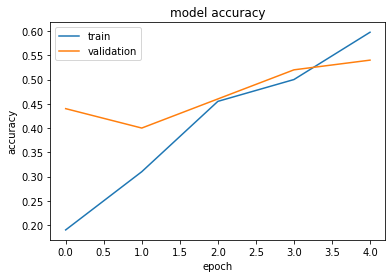

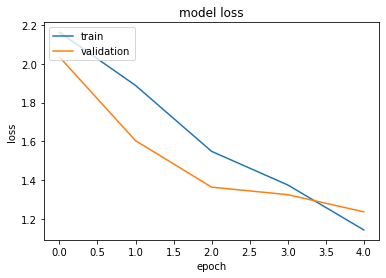

In [211]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [212]:
loss, acc = model.evaluate(test_x, test_y)
print("Test set accuracy: ",acc)
print("Test set loss: ", loss)

50/50 [==============================] - 0s 3ms/step
Test set accuracy:  0.5400000214576721
Test set loss:  1.2699434709548951


## Predict some examples

In [282]:
def predict(text):
    encoded_text = encode_texts([text])

    probs = model.predict(encoded_text)[0]
    print("Prediction result:", probs)

    pred_label_index = np.argmax(probs)
    pred_label = index_labels[pred_label_index]
    pred_prob = probs[pred_label_index]

    print(f"Prediction: {pred_label.upper()} with confidence: {pred_prob}.")

In [283]:
text = "I usually really love German movies. However, this movie was just too much for me. The director did a bad job in cutting the scenes and the overall acting performance was just not sufficient in my eyes."
predict(text)

Prediction result: [0.08363204 0.02674557 0.17692816 0.01426391 0.05273069 0.5257366
 0.02846334 0.0158299  0.07566986]
Prediction: WEB with confidence: 0.5257365703582764.


In [285]:
encoded_text = encode_texts([text])

probs = model.predict(encoded_text)[0]

In [309]:
numbers = range(10)
{n:probs[n] for n in range(len(probs))}

{0: 0.08363204,
 1: 0.026745567,
 2: 0.17692816,
 3: 0.014263911,
 4: 0.052730694,
 5: 0.5257366,
 6: 0.028463336,
 7: 0.015829902,
 8: 0.07566986}

## Visualize attention

In [216]:
def _get_attention_weights(sequenceSentence,weights):
    """
    The same function as the AttentionLayer class.
    """
    uit = np.dot(sequenceSentence, weights[0]) + weights[1]
    uit = np.tanh(uit)

    ait = np.dot(uit, weights[2])
    ait = np.squeeze(ait)
    ait = np.exp(ait)
    ait /= np.sum(ait)
    
    return ait

In [271]:
def predict_and_visualize_attention(text):
    encoded_text = encode_texts([text])[0]
    
    normalized_text = normalize(text)
    
    # word level attention
    hidden_word_encoding_out = Model(inputs=wordEncoder.get_layer('word_input').output,
                                     outputs=wordEncoder.get_layer('word_dense').output)

    hidden_word_encodings = hidden_word_encoding_out.predict(encoded_text)
    word_context = wordEncoder.get_layer('word_attention').get_weights()
    word_attentions = _get_attention_weights(hidden_word_encodings, word_context)
   
    # sentence level attention
    hidden_sent_encoding_out = Model(inputs=model.get_layer("sent_input").output,
                                         outputs=[model.get_layer("output").output,
                                                  model.get_layer('sent_dense').output])
    output_array = hidden_sent_encoding_out.predict(np.expand_dims(encoded_text, 0))
    sentence_attentions = _get_attention_weights(output_array[1],model.get_layer('sent_attention').get_weights())

    prediction = output_array[0]
    
    attention_result = []
        out_sent_num = min(len(normalized_text), len(sentence_attentions))
        sum_s_att = sum(sentence_attentions[:out_sent_num])
        for i in range(out_sent_num):
            wa = word_attentions[i][:len(normalized_text[i])]
            wa = wa / wa.sum(axis=0, keepdims=1)
            attention_result.append([sentence_attentions[i] / sum_s_att,[[w, a] for w, a in zip(wa, normalized_text[i])]])

        return list(prediction[0]), attention_result

In [272]:
def scale_color_h_hex(c_h, scale):
    return matplotlib.colors.to_hex(matplotlib.colors.hsv_to_rgb((c_h, scale, 1)))
def red_background_hex(scale):
    return scale_color_h_hex(0, scale)
def blue_background_hex(scale):
    return scale_color_h_hex(0.625, scale)

In [277]:
def visualize_attention_html(attentions):
    html_response = "<table>"
    for a in list(attentions):
        html_response += "<tr>"
        sent_color = red_background_hex(a[0])
        html_response += f"<td bgcolor=\"{sent_color}\"></td>"
        text = ""
        for i in range(len(a[1])):
            t_color = blue_background_hex(np.sqrt(a[0])*a[1][i][0]) # visualize attentions as sqrt(p_s)*p_w as recommended in paper
            text += f"<td bgcolor=\"{t_color}\">{a[1][i][1]}</td>"
        html_response += text
        html_response += "</tr>"
    html_response += "</table>"
    return html_response

In [311]:
text = test.text.iloc[9]
prediction, attentions = predict_and_visualize_attention(text)

pred_label_index = np.argmax(prediction)
pred_label = index_labels[pred_label_index]
pred_prob = prediction[pred_label_index]

print(f"Prediction: {pred_label.upper()} with confidence {pred_prob:.2f}")
for i, l in enumerate(labels_index.keys()):
    print(f"{l}: {prediction[i]:.2f}")

html_response = visualize_attention_html(attentions)
display(HTML(html_response))

Prediction: SPORT with confidence 0.95
Sport: 0.95
Wirtschaft: 0.00
Kultur: 0.01
Inland: 0.01
Etat: 0.02
Web: 0.00
Panorama: 0.01
International: 0.00
Wissenschaft: 0.00
